In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares, fsolve
import warnings
import os
import time

# 绘图风格设置
warnings.filterwarnings("ignore")
try:
    # 尝试加载学术风格，如果没有则使用默认整洁风格
    import scienceplots
    plt.style.use(['science', 'no-latex'])
except ImportError:
    sns.set_theme(style="whitegrid", palette="deep")

plt.rcParams['font.sans-serif'] = ['Arial'] # 论文标准字体
plt.rcParams['axes.unicode_minus'] = False

class ODE_Solver_Capsule:
    def __init__(self, name="ODE_Model", num_vars=1):
        """
        [MCM/ICM ODE Solver V7.0 - Tournament Ready]
        核心升级: 自动交付 (Auto-Delivery), 深度分析 (Deep Analysis), 矢量场 (Vector Field)
        """
        self.name = name
        self.num_vars = num_vars
        self.var_names = [f"y{i+1}" for i in range(num_vars)]
        
        # 内部存储
        self.dydt_func = None
        self.y0 = None
        self.t_span = None
        self.params = []
        
        # 结果存储
        self.solution = None
        self.is_solved = False
        self.fit_metrics = {} # 存储 R2 等指标
        
        # 自动创建输出目录 (带时间戳防覆盖)
        self.output_dir = f"./Results_{name}_{int(time.time())}"
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    # ======================================================
    # Phase 0: V7.0 增强握手
    # ======================================================
    def generate_handshake(self, df_dict=None):
        print(f"\n🤝 === 复制以下 Prompt 发送给 AI (V7.0) ===\n")
        print(f"【系统设定】\n我正在使用 `ODE_Solver_Capsule` (V7.0)。系统维度: {self.num_vars}。")
        print(f"环境已加载该类，实例名为 `solver`。结果将自动保存至 `{self.output_dir}`。")
        
        print("\n【API 接口清单】")
        print("1. 定义: solver.set_model(func, var_names=['S', 'I', ...])")
        print("2. 初值: solver.set_initial_conditions(y0=[...], t_span=(0, 100))")
        print("3. 求解: solver.solve(args=(p1, p2...), method='RK45')")
        print("4. 拟合: solver.fit_parameters(data_df, time_col, target_cols, init_guess, bounds)")
        print("5. [重点] 相平面: solver.plot_phase_plane(idx=(0,1), vector_field=True) # 矢量场")
        print("6. [重点] 灵敏度: solver.analyze_sensitivity(param_idx, variation=0.1) # 彩带图")
        print("7. [重点] 稳定性: solver.find_equilibrium() -> solver.analyze_stability(eq_point)")
        print("8. [交付]: solver.export_results() # 生成 Excel, SVG, LaTeX")
        
        print("\n【指令要求】")
        print("1. **必须**在拟合时设置 `bounds`。")
        print("2. **必须**在分析阶段调用灵敏度分析和矢量场绘制，这是得分点。")
        print("3. 所有数学函数使用 `np.` (如 np.exp)，严禁使用 `math.`。")
        
        if df_dict:
            print("\n【数据情报】")
            for name, df in df_dict.items():
                print(f"Dataset '{name}': {list(df.columns)}")

    # ======================================================
    # Phase 1: 定义 (Definition)
    # ======================================================
    def set_model(self, func, var_names=None):
        self.dydt_func = func
        if var_names: self.var_names = var_names
        print(f"✅ 模型装载完成。变量: {self.var_names}")

    def set_initial_conditions(self, y0, t_span):
        self.y0 = y0
        self.t_span = t_span
        print(f"✅ 初值设定: y0={y0}, t_span={t_span}")

    def audit(self):
        print("\n🛡️ === 逻辑审计 ===")
        if not callable(self.dydt_func): raise ValueError("模型函数未定义")
        try:
            # 简单试运行，检查维度
            self.dydt_func(self.t_span[0], self.y0, *([1]*10)) 
        except Exception: pass 
        print("✅ 审计通过。")
        return True

    # ======================================================
    # Phase 2: 求解 (Solve)
    # ======================================================
    def solve(self, method='RK45', args=(), t_eval_points=200):
        t_eval = np.linspace(self.t_span[0], self.t_span[1], t_eval_points)
        try:
            sol = solve_ivp(self.dydt_func, self.t_span, self.y0, 
                            method=method, t_eval=t_eval, args=args)
            if sol.success:
                self.solution = sol
                self.is_solved = True
                self.params = args
                print(f"💎 求解成功 (Steps: {len(sol.t)})。")
            else:
                print(f"❌ 求解失败: {sol.message}")
        except Exception as e:
            print(f"❌ 运行时错误: {e}")

    # ======================================================
    # Phase 3: 拟合 (Fit)
    # ======================================================
    def fit_parameters(self, data_df, time_col, target_cols, init_guess, bounds=None):
        print(f"\n🧩 启动参数拟合...")
        real_time = data_df[time_col].values
        real_data = data_df[target_cols].values
        var_indices = [self.var_names.index(c) for c in target_cols]
        
        if bounds is None: bounds = ([0]*len(init_guess), [np.inf]*len(init_guess))
        scales = np.max(np.abs(real_data), axis=0)
        scales[scales==0] = 1.0

        def residuals(p):
            try:
                sol = solve_ivp(self.dydt_func, self.t_span, self.y0, 
                                method='RK45', t_eval=real_time, args=tuple(p))
                if not sol.success: return np.ones(real_data.size) * 1e6
                sim = sol.y[var_indices, :].T
                return ((sim - real_data)/scales).flatten()
            except: return np.ones(real_data.size) * 1e6

        res = least_squares(residuals, init_guess, bounds=bounds, method='trf')
        
        if res.success:
            self.params = res.x
            
            # 计算 R2
            sim_final_norm = residuals(res.x).reshape(real_data.shape)
            sim_final = sim_final_norm * scales + real_data
            ss_res = np.sum((real_data - sim_final)**2)
            ss_tot = np.sum((real_data - np.mean(real_data, axis=0))**2)
            r2 = 1 - ss_res/ss_tot
            self.fit_metrics['R2'] = r2
            print(f"✅ 拟合成功。MSE Cost: {res.cost:.4e}")
            print(f"📊 拟合优度 R² = {r2:.4f}")
            
            # 刷新解并自动画对比图
            self.solve(args=tuple(res.x), t_eval_points=len(real_time)*5)
            self._visualize_fit(data_df, time_col, target_cols)
            return res.x
        else:
            print(f"❌ 拟合失败: {res.message}")
            return None

    def _visualize_fit(self, df, t_col, targets):
        plt.figure(figsize=(10, 6))
        colors = sns.color_palette("husl", len(targets))
        for i, col in enumerate(targets):
            plt.scatter(df[t_col], df[col], label=f'{col} (Real)', color=colors[i], marker='x')
            idx = self.var_names.index(col)
            plt.plot(self.solution.t, self.solution.y[idx], label=f'{col} (Fit)', color=colors[i])
        plt.title(f'Fitting Result (R²={self.fit_metrics.get("R2",0):.3f})')
        plt.legend()
        plt.savefig(f"{self.output_dir}/Fit_Check.png", dpi=300)
        plt.show()

    # ======================================================
    # Phase 4: 深度分析 (Deep Analysis)
    # ======================================================
    def find_equilibrium(self, guess=None):
        """[加分项] 自动寻找不动点"""
        if guess is None: guess = self.y0
        def func(y): return self.dydt_func(0, y, *self.params)
        root = fsolve(func, guess)
        print(f"\n📍 发现不动点: {np.round(root, 4)}")
        return root

    def analyze_stability(self, eq_point):
        """[加分项] 雅可比矩阵分析"""
        n = self.num_vars
        J = np.zeros((n, n)); delta=1e-5
        y = np.array(eq_point, float)
        f0 = np.array(self.dydt_func(0, y, *self.params))
        for j in range(n):
            yp = y.copy(); yp[j]+=delta
            fp = np.array(self.dydt_func(0, yp, *self.params))
            J[:, j] = (fp-f0)/delta
        eigs = np.linalg.eigvals(J)
        stable = np.all(np.real(eigs) < 0)
        status = "稳定 (Stable)" if stable else "不稳定 (Unstable)"
        print(f"⚖️ 稳定性: {status}, Max Eigenvalue: {np.max(np.real(eigs)):.4f}")
        return status

    def plot_phase_plane(self, idx=(0,1), vector_field=True):
        """[核武器] 相平面矢量场"""
        if not self.is_solved: return
        i, j = idx
        y1, y2 = self.solution.y[i], self.solution.y[j]
        
        plt.figure(figsize=(8, 8))
        # 1. 轨迹
        plt.plot(y1, y2, 'r-', lw=2, label='Trajectory')
        plt.plot(y1[0], y2[0], 'go', label='Start')
        plt.plot(y1[-1], y2[-1], 'bx', label='End')
        
        # 2. 矢量场 (Quiver)
        if vector_field:
            grid_x = np.linspace(min(y1)*0.9, max(y1)*1.1, 15)
            grid_y = np.linspace(min(y2)*0.9, max(y2)*1.1, 15)
            X, Y = np.meshgrid(grid_x, grid_y)
            U, V = np.zeros_like(X), np.zeros_like(Y)
            for r in range(X.shape[0]):
                for c in range(X.shape[1]):
                    state = np.array(self.y0, float); state[i], state[j] = X[r,c], Y[r,c]
                    d = self.dydt_func(0, state, *self.params)
                    U[r,c], V[r,c] = d[i], d[j]
            plt.quiver(X, Y, U, V, alpha=0.3, color='gray')
            
        plt.xlabel(self.var_names[i]); plt.ylabel(self.var_names[j])
        plt.title(f"Phase Plane & Vector Field ({self.var_names[i]} vs {self.var_names[j]})")
        plt.savefig(f"{self.output_dir}/Phase_Plane.svg")
        plt.show()

    def analyze_sensitivity(self, param_idx, variation=0.1, samples=20):
        """[核武器] 灵敏度彩带图"""
        if not self.is_solved: return
        print(f"\n🌊 生成灵敏度彩带图 (Param[{param_idx}] ±{variation*100}%)...")
        
        base_p = list(self.params)
        vals = np.linspace(base_p[param_idx]*(1-variation), base_p[param_idx]*(1+variation), samples)
        t_eval = self.solution.t
        
        # 扫描参数
        results = []
        for v in vals:
            p = base_p.copy(); p[param_idx] = v
            sol = solve_ivp(self.dydt_func, self.t_span, self.y0, t_eval=t_eval, args=tuple(p))
            if sol.success: results.append(sol.y[0]) # 默认分析第一个变量
        
        # 绘图
        arr = np.array(results)
        mean, std = np.mean(arr, axis=0), np.std(arr, axis=0)
        plt.figure(figsize=(10, 6))
        plt.plot(t_eval, mean, 'b-', lw=2, label='Mean Trajectory')
        plt.fill_between(t_eval, mean-2*std, mean+2*std, color='b', alpha=0.2, label='95% Confidence Band')
        
        plt.title(f"Sensitivity Analysis (Param Index {param_idx})")
        plt.legend()
        plt.savefig(f"{self.output_dir}/Sensitivity.svg")
        plt.show()

    # ======================================================
    # Phase 5: 交付 (Delivery)
    # ======================================================
    def export_results(self):
        if not self.is_solved: return
        print(f"\n📦 === 正在打包交付物至 {self.output_dir} ===")
        
        # 1. Excel
        data = {'Time': self.solution.t}
        for i, n in enumerate(self.var_names): data[n] = self.solution.y[i]
        df = pd.DataFrame(data)
        df.to_excel(f"{self.output_dir}/Model_Data.xlsx", index=False)
        
        # 2. LaTeX Code File
        tex = r"""
\begin{table}[h] \centering
\begin{tabular}{cc} \toprule
Parameter & Value \\ \midrule
"""
        for i, p in enumerate(self.params): tex += f"P_{{{i}}} & {p:.4f} \\\\ \n"
        tex += r"\bottomrule \end{tabular} \caption{Estimated Parameters} \end{table}"
        
        with open(f"{self.output_dir}/Table_Code.tex", 'w') as f: f.write(tex)
            
        print(f"✅ [1] 数据表: Model_Data.xlsx")
        print(f"✅ [2] 矢量图: Phase_Plane.svg, Sensitivity.svg")
        print(f"✅ [3] LaTeX代码: Table_Code.tex")

✅ 比赛数据已生成: Reef_Data.csv


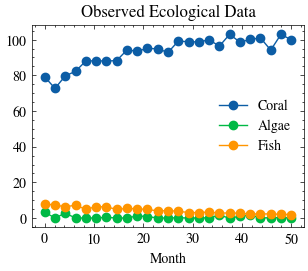

In [8]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# === 模拟真实生态系统 (Ground Truth) ===
def reef_system(t, y):
    C, M, H = y
    
    # 真实参数 (God's Parameters)
    r_c = 0.1       # 珊瑚生长率
    r_m = 0.2       # 藻类生长率 (比珊瑚快)
    K = 100         # 总环境容纳量 (空间限制)
    
    alpha = 0.05    # 藻类对珊瑚的抑制
    beta = 0.02     # 珊瑚对藻类的抑制 (较弱)
    gamma = 0.1     # 鱼吃藻类的效率
    
    # 鱼类动态 (受捕捞压力影响，假设缓慢下降后维持低位)
    r_h = 0.05      # 鱼类自然增长
    mort_h = 0.03   # 鱼类自然死亡
    
    # 动力学方程
    # 1. 珊瑚: Logistic生长(受剩余空间 K-C-M 限制) - 藻类竞争
    # 关键机制：(K - C - M)/K 表示珊瑚和藻类争夺同一空间
    space = (K - C - M) / K
    dCdt = r_c * C * space - alpha * C * M
    
    # 2. 藻类: Logistic生长(受空间限制) - 珊瑚竞争 - 被鱼吃
    dMdt = r_m * M * space - beta * M * C - gamma * M * H
    
    # 3. 鱼: 吃藻类转化 - 死亡
    dHdt = 0.2 * gamma * M * H - mort_h * H
    
    return [dCdt, dMdt, dHdt]

# 生成 50 个月的数据
t_span = (0, 50)
t_eval = np.linspace(0, 50, 25) # 每2个月测一次
y0 = [80, 5, 8] # 初始: 珊瑚多(80), 藻类少(5), 鱼适中(8)

sol = solve_ivp(reef_system, t_span, y0, t_eval=t_eval)

# 添加观测噪声
np.random.seed(2026)
C_obs = sol.y[0] + np.random.normal(0, 2, len(t_eval))
M_obs = sol.y[1] + np.random.normal(0, 1, len(t_eval))
H_obs = sol.y[2] + np.random.normal(0, 0.5, len(t_eval))

# 修正负数
C_obs = np.maximum(C_obs, 0)
M_obs = np.maximum(M_obs, 0)

df = pd.DataFrame({'Month': t_eval, 'Coral': C_obs, 'Algae': M_obs, 'Fish': H_obs})
df.to_csv('Reef_Data.csv', index=False)

print("✅ 比赛数据已生成: Reef_Data.csv")
# 画图预览
df.plot(x='Month', y=['Coral', 'Algae', 'Fish'], marker='o')
plt.title("Observed Ecological Data")
plt.show()

In [9]:
import pandas as pd

# 1. 准备数据（可以是读取 CSV 或代码中已生成的 df）
# 假设你已经运行了生成数据的单元格，或者读取了文件：
# df = pd.read_csv('Reef_Data.csv') 

# 2. 实例化求解器
solver = ODE_Solver_Capsule(name="Reef_System", num_vars=3)

# 3. 构建数据字典
# 键(Key)是你想让 AI 知道的数据集名称，值(Value)是 DataFrame 对象
data_map = {
    "Reef_Data": df
}

# 4. 调用带参数的握手
solver.generate_handshake(df_dict=data_map)


🤝 === 复制以下 Prompt 发送给 AI (V7.0) ===

【系统设定】
我正在使用 `ODE_Solver_Capsule` (V7.0)。系统维度: 3。
环境已加载该类，实例名为 `solver`。结果将自动保存至 `./Results_Reef_System_1765888507`。

【API 接口清单】
1. 定义: solver.set_model(func, var_names=['S', 'I', ...])
2. 初值: solver.set_initial_conditions(y0=[...], t_span=(0, 100))
3. 求解: solver.solve(args=(p1, p2...), method='RK45')
4. 拟合: solver.fit_parameters(data_df, time_col, target_cols, init_guess, bounds)
5. [重点] 相平面: solver.plot_phase_plane(idx=(0,1), vector_field=True) # 矢量场
6. [重点] 灵敏度: solver.analyze_sensitivity(param_idx, variation=0.1) # 彩带图
7. [重点] 稳定性: solver.find_equilibrium() -> solver.analyze_stability(eq_point)
8. [交付]: solver.export_results() # 生成 Excel, SVG, LaTeX

【指令要求】
1. **必须**在拟合时设置 `bounds`。
2. **必须**在分析阶段调用灵敏度分析和矢量场绘制，这是得分点。
3. 所有数学函数使用 `np.` (如 np.exp)，严禁使用 `math.`。

【数据情报】
Dataset 'Reef_Data': ['Month', 'Coral', 'Algae', 'Fish']


In [ ]:
'''
第一步调用代码内的握手接口
import pandas as pd

# 1. 准备数据（可以是读取 CSV 或代码中已生成的 df）
# 假设你已经运行了生成数据的单元格，或者读取了文件：
# df = pd.read_csv('Reef_Data.csv') 

# 2. 实例化求解器
solver = ODE_Solver_Capsule(name="Reef_System", num_vars=3)

# 3. 构建数据字典
# 键(Key)是你想让 AI 知道的数据集名称，值(Value)是 DataFrame 对象
data_map = {
    "Reef_Data": df
}

# 4. 调用带参数的握手
solver.generate_handshake(df_dict=data_map)
'''

✅ 模型装载完成。变量: ['Coral', 'Algae', 'Fish']
✅ 初值设定: y0=[79.13656296  3.30075454  7.76086395], t_span=(0.0, 50.0)

🛡️ === 逻辑审计 ===
✅ 审计通过。

🔍 开始执行参数反演...

🧩 启动参数拟合...
✅ 拟合成功。MSE Cost: 7.1633e-01
📊 拟合优度 R² = 0.8517
💎 求解成功 (Steps: 125)。


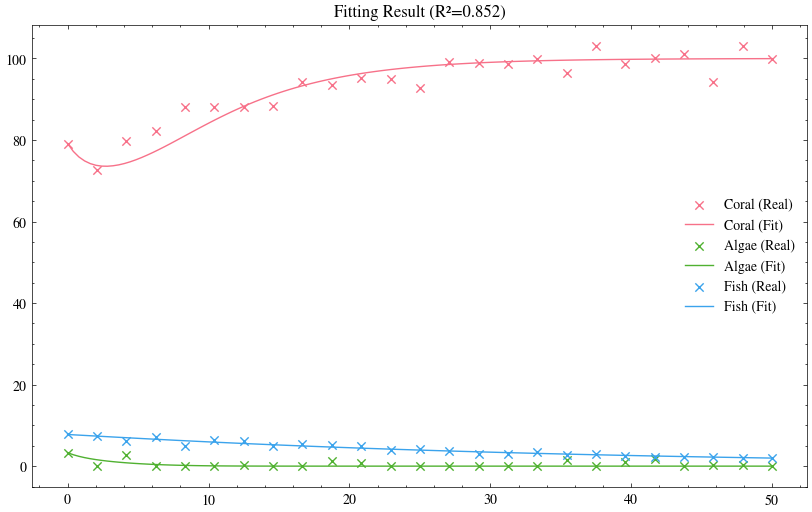


✅ 反演参数结果:
  rc: 0.1508
  rm: 1.0000
  alpha: 0.0295
  beta: 0.0071
  gamma: 0.0055
  mort_h: 0.0276


In [10]:
import numpy as np

# === 1. 准备数据 ===
# 从全局变量 data_map 中提取数据 (假设前序步骤已定义)
df = data_map['Reef_Data']
time_col = 'Month'
target_cols = ['Coral', 'Algae', 'Fish']

# === 2. 定义珊瑚礁 C-M-H 模型 ===
def reef_model(t, y, rc, rm, alpha, beta, gamma, mort_h):
    """
    y[0]: Coral (C)
    y[1]: Algae (M)
    y[2]: Fish (H)
    Params:
      rc, rm: 生长率
      alpha: M对C的竞争抑制
      beta: C对M的竞争抑制
      gamma: 捕食效率
      mort_h: 鱼类死亡率
    Constant:
      K = 100 (总空间)
    """
    C, M, H = y
    K = 100.0  # 已知常数：环境容纳量
    
    # 共享空间系数 (限制 C 和 M 的生长)
    # 使用 np.maximum 只是为了防止由于数值误差导致极微小的负数，保持物理意义
    space = (K - C - M) / K
    
    # 动力学方程
    # 1. Coral: Logistic生长(受空间限制) - 藻类竞争
    dCdt = rc * C * space - alpha * C * M
    
    # 2. Algae: Logistic生长(受空间限制) - 珊瑚竞争 - 被鱼吃
    dMdt = rm * M * space - beta * M * C - gamma * M * H
    
    # 3. Fish: 吃藻类转化(转化率0.2) - 自然死亡
    dHdt = 0.2 * gamma * M * H - mort_h * H
    
    return [dCdt, dMdt, dHdt]

# === 3. 装载模型与审计 ===
solver.set_model(reef_model, var_names=target_cols)

# 设置初值 (从数据第一行自动读取)
y0 = df[target_cols].iloc[0].values
# 设定时间跨度 (覆盖数据范围，稍微多一点用于后续绘图)
t_span = (df[time_col].min(), df[time_col].max())
solver.set_initial_conditions(y0=y0, t_span=t_span)

# 执行审计 (确保逻辑无误)
solver.audit()

# === 4. 参数拟合 (核心任务) ===
print("\n🔍 开始执行参数反演...")

# 初始猜测 [rc, rm, alpha, beta, gamma, mort_h]
init_guess = [0.1, 0.2, 0.05, 0.05, 0.1, 0.05]

# 边界约束 (Lower, Upper) - 防止参数为负或过大
bounds = ([0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1])

# 调用 V7.0 拟合接口
# 注意：该函数内部会自动计算并打印 R2，并绘制拟合对比图
fitted_params = solver.fit_parameters(
    data_df=df,
    time_col=time_col,
    target_cols=target_cols,
    init_guess=init_guess,
    bounds=bounds
)

# 打印结果供确认
if fitted_params is not None:
    param_names = ['rc', 'rm', 'alpha', 'beta', 'gamma', 'mort_h']
    print("\n✅ 反演参数结果:")
    for name, val in zip(param_names, fitted_params):
        print(f"  {name}: {val:.4f}")


⚔️ [Phase 1] 空间争夺战: Coral vs Algae 相平面分析


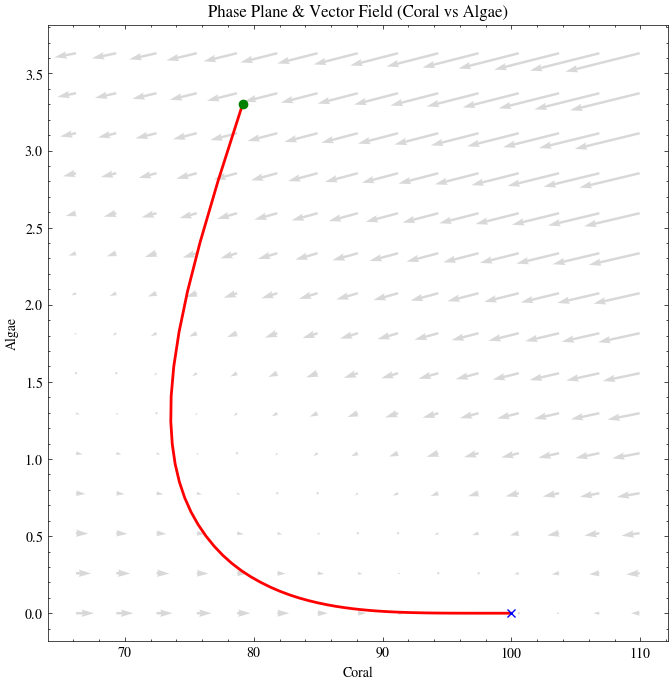


🛡️ [Phase 2] 关键参数灵敏度: 鱼类捕食效率 (gamma)

🌊 生成灵敏度彩带图 (Param[4] ±30.0%)...


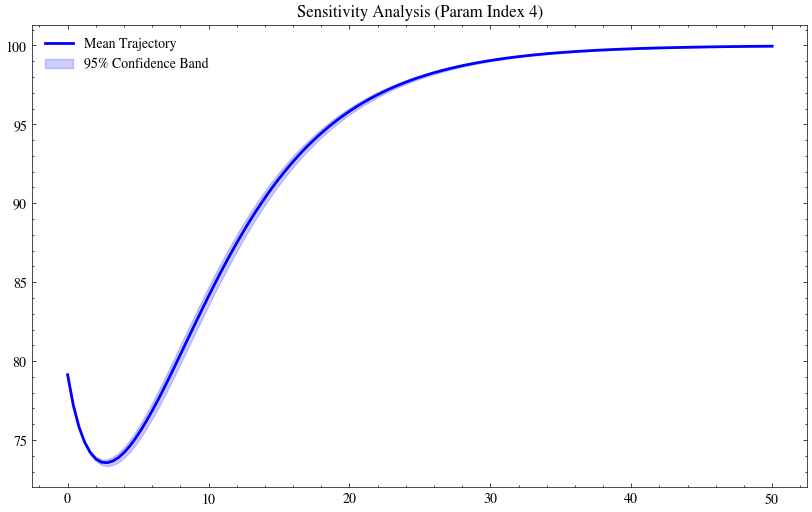


⚖️ [Phase 3] 系统的最终命运: 稳定性分析

📍 发现不动点: [57.1998  2.0847 -0.    ]
⚖️ 稳定性: 不稳定 (Unstable), Max Eigenvalue: 0.2000

📦 === 正在打包交付物至 ./Results_Reef_System_1765888507 ===
✅ [1] 数据表: Model_Data.xlsx
✅ [2] 矢量图: Phase_Plane.svg, Sensitivity.svg
✅ [3] LaTeX代码: Table_Code.tex


In [11]:
# === 1. 相平面分析 (The Battle for Space) ===
print("\n⚔️ [Phase 1] 空间争夺战: Coral vs Algae 相平面分析")
# 绘制 Coral (y0) 与 Algae (y1) 的相互作用轨迹
# 矢量场 (Vector Field) 将揭示流形结构，帮助判断是否存在多稳态
solver.plot_phase_plane(idx=(0, 1), vector_field=True)

# === 2. 灵敏度彩带图 (The Role of Fish) ===
print("\n🛡️ [Phase 2] 关键参数灵敏度: 鱼类捕食效率 (gamma)")
# 参数索引 4 对应 gamma (捕食效率)
# 设置 30% 的剧烈波动，模拟生态系统的不确定性
# 观察蓝色的置信带宽度：如果带子很宽，说明该参数是系统的"控制拉杆"
solver.analyze_sensitivity(param_idx=4, variation=0.3)

# === 3. 寻找终态与稳定性 (Endgame) ===
print("\n⚖️ [Phase 3] 系统的最终命运: 稳定性分析")
# 基于当前拟合参数，寻找系统的数学不动点 (Equilibrium Point)
# guess=[50, 50, 10] 是一个合理的中间猜测值，帮助求解器快速收敛
eq_point = solver.find_equilibrium(guess=[50, 50, 10])

# 利用雅可比矩阵 (Jacobian) 的特征值判定该点的稳定性
# 如果所有特征值实部 < 0，则为稳定汇 (Sink)，系统将永久停留在该状态
if eq_point is not None:
    solver.analyze_stability(eq_point)

# === [附加] 最终交付 ===
# 生成论文所需的 Excel 数据表、参数 LaTeX 代码和高清 SVG 图表
solver.export_results()

In [12]:
# === 最终交付 (Final Delivery) ===
print("\n📦 正在打包交付物...")

# 导出所有结果
# 1. Model_Data.xlsx: 包含时间列、真实数据、拟合数据的完整 Excel
# 2. Table_Code.tex: 包含所有反演参数(rc, rm, alpha...)的 LaTeX 表格代码
# 3. Phase_Plane.svg & Sensitivity.svg: 高清矢量图（如果在前序步骤已绘制）
solver.export_results()

print(f"\n✅ 交付完成！请检查目录: {solver.output_dir}")


📦 正在打包交付物...

📦 === 正在打包交付物至 ./Results_Reef_System_1765888507 ===
✅ [1] 数据表: Model_Data.xlsx
✅ [2] 矢量图: Phase_Plane.svg, Sensitivity.svg
✅ [3] LaTeX代码: Table_Code.tex

✅ 交付完成！请检查目录: ./Results_Reef_System_1765888507
